## Preprocessing

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from datetime import timedelta
from itertools import product
from collections import Counter, defaultdict

# RINGITY IMPORTS
import ringity as rng
import ringity.utils.plotting as rplotting
import ringity.networks.networkmodel.distributions as rdist
import ringity.networks.networkmodel.transformations as rtrafo

from ringity.utils import exceptions as rexceptions

rplotting.set_theme()
DIRNAME_DATA = Path.cwd().parent / 'data'
DIRNAME_PLOTS = DIRNAME_DATA / 'plots'

In [2]:
t1 = time.time()

### Set model parameters

In [3]:
config_dict = {
    'default' : {
        'c' : 0.25,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'longer_response' : {
        'c' : 0.25,
        'r' : 0.375,
        'beta' : 1,
        'rho' : None,
    },
    'stronger_coupling' : {
        'c' : 0.375,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'shorter_delay' : {
        'c' : 0.25,
        'r' : 0.25,
        'beta' : 0.75,
        'rho' : None,
    },
    'higher_density_fixed_response' : {
        'c' : None,
        'r' : 0.25,
        'beta' : 1,
        'rho' : 0.0625,
    },
    'higher_density_fixed_coupling' : {
        'c' : 0.25,
        'r' : None,
        'beta' : 1,
        'rho' : 0.0625,
    }
}

In [4]:
N = 2**10

N_ENSEMBLE = 2**3
N_ARG_POINTS = 2**4

### Auciliary functions

In [9]:
def draw_interaction_function(builder):
    
    intfunc_fig, ax = plt.subplots(figsize = (8,5))
    
    c = builder.coupling
    r = builder.response
    
    x = np.linspace(0, np.pi, 100)
    y = c*(1-x/(2*np.pi*r)).clip(0)

    ax.plot(x, y, linewidth = 5)

    plt.xticks([1, 2, 2*np.pi*r, np.pi], [r'$1$', r'$2$', r'$2\pi r$', r'$\pi$'])
    plt.yticks([0, 0.25, 0.5, 1, c], [r'$0$', r'$0.25$', r'$0.5$', r'$1$', r'$c$'])

    ax.set_ylim(-0.025, max(0.5, c) + 0.025)
    
    return intfunc_fig


def draw_network_visualiztion(builder, N = 2**9, layout = 'both'):
    
    G, pos = rng.network_model(
                                N = N,
                                return_positions = True,
                                c = builder.coupling,
                                r = builder.response,
                                rho = builder.density,
                                beta = builder.delay)
    
    circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
    spring_layout = nx.spring_layout(G)
    
    if layout == 'both':
        netviz_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
        ax1.set_xlim(-1.175,1.175)
        ax1.set_ylim(-1.175,1.175)

        ax2.set_xlim(-1.175,1.175)
        ax2.set_ylim(-1.175,1.175)
    else:
        netviz_fig, ax = plt.subplots(figsize = (6,5))
        ax.set_xlim(-1.175,1.175)
        ax.set_ylim(-1.175,1.175)
        
    if   layout == 'spring':
        rng.plot_nx(G, ax=ax, pos = spring_layout)
    elif layout == 'circular':
        rng.plot_nx(G, ax=ax, pos = circ_layout)
    elif layout == 'both':
        rng.plot_nx(G, ax=ax1, pos = circ_layout)
        rng.plot_nx(G, ax=ax2, pos = spring_layout)
    
    return netviz_fig

# Network model exploration

## Default model

In [10]:
configuration = 'default'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **config_dict[configuration])

### Interaction function

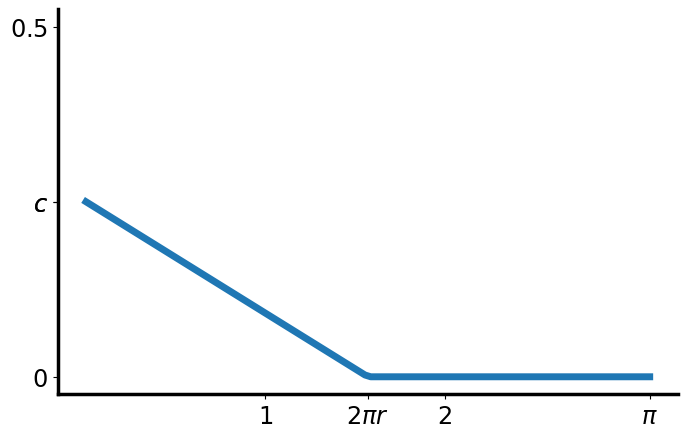

In [11]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

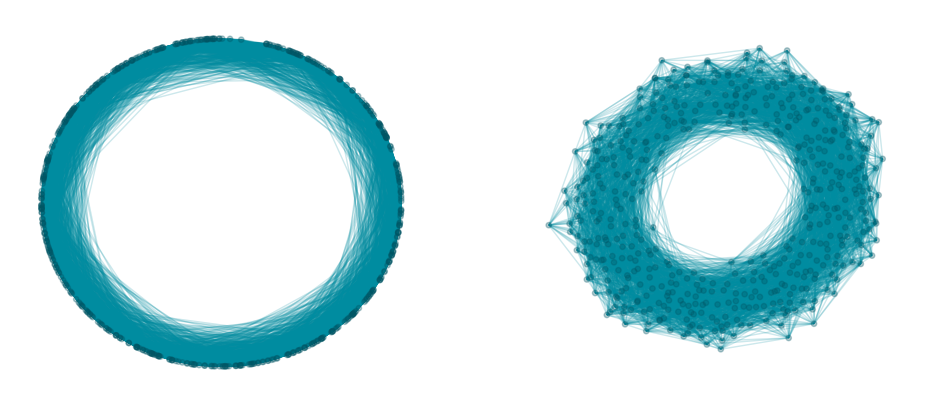

In [12]:
netviz_fig = draw_network_visualiztion(builder, N = 2**9, layout = 'both')

### Clustering coefficient

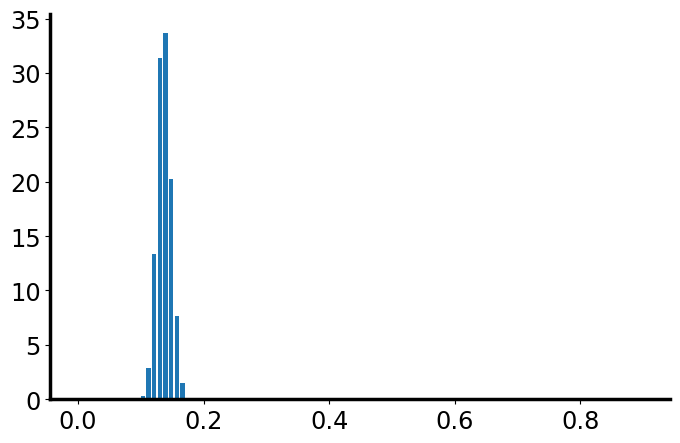

In [10]:
clust = []

for _ in range(N_ENSEMBLE):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.networks.clustering_coefficient(G))

clustdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=100, range=(0, 0.9), 
        rwidth = 0.75, density = True);

# xlabel = ax.set_xlabel('clustering coefficient', fontsize=18)
# ylabel = ax.set_ylabel('frequency', fontsize=18)

In [11]:
c = builder.coupling
r = builder.response
beta = builder.delay

degs_exp = [p for theta in rdist.delaydist.rvs(size=N, beta=beta) for p in np.random.binomial(N-1, rtrafo.local_density(theta=theta, r=r, c=c, beta=beta), size=2**10)]

degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

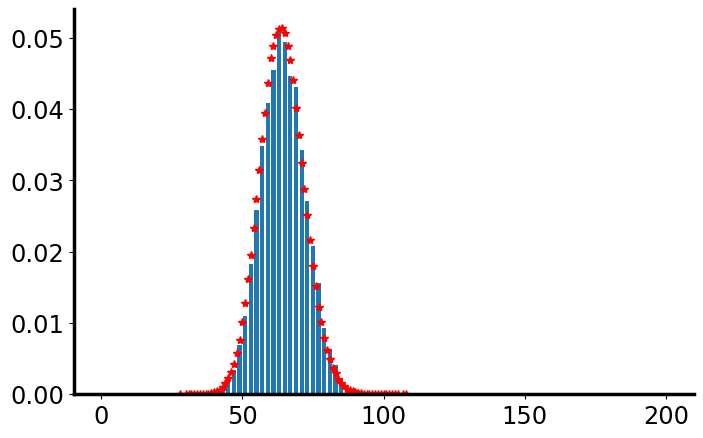

In [12]:
degs = []

for _ in range(N_ENSEMBLE):
    G = rng.network_model(N=N, **config_dict[configuration])
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

degdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 100, range = (0, 200),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


#ax.set_xlabel('degree', fontsize=18)
#ax.set_ylabel('frequency', fontsize=18)

### ring-score distribution

In [13]:
n_ensemble = N_ENSEMBLE
n_arg_points = 9

arg_list = np.logspace(8, 10, n_arg_points, base=2, dtype=int)

total = len(arg_list) * n_ensemble
pbar = tqdm(product(arg_list, range(n_ensemble)), total = total)

score = defaultdict(list)
for arg, _ in pbar:
    G = rng.network_model(N = arg, **config_dict[configuration])
    try:
        score[arg].append(rng.ring_score(G))
    except rexceptions.DisconnectedGraphError:
        continue

100%|███████████████████████████████████████████| 72/72 [02:19<00:00,  1.93s/it]


In [14]:
chunks_score_df = [
    pd.DataFrame(scores, columns=['score']).assign(N=arg) for arg, scores in score.items()
]

score_df = pd.concat(chunks_score_df, ignore_index=True)
plot_df = score_df.groupby('N').describe()['score']

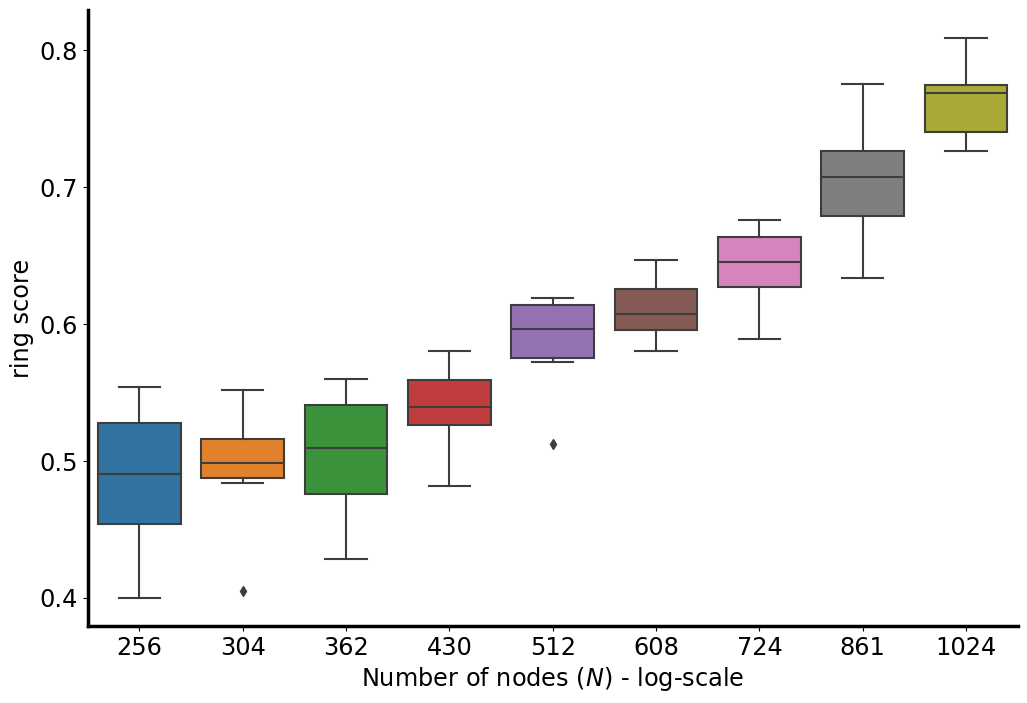

In [15]:
ringdist_fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(score_df, x='N', y='score', ax = ax)
xticks = plt.xticks(np.linspace(0, n_arg_points-1, n_arg_points), arg_list)

xlabel = ax.set_xlabel(r'Number of nodes ($N$) - log-scale')
ylabel = ax.set_ylabel(r'ring score')

In [16]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png")
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf")

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")

# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.png")
# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.pdf")

# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.png")
# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.pdf")

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png")
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf")

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png")
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf")

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png")
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf")

---

## Longer Response

In [14]:
configuration = 'longer_response'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **config_dict[configuration])

### Interaction function

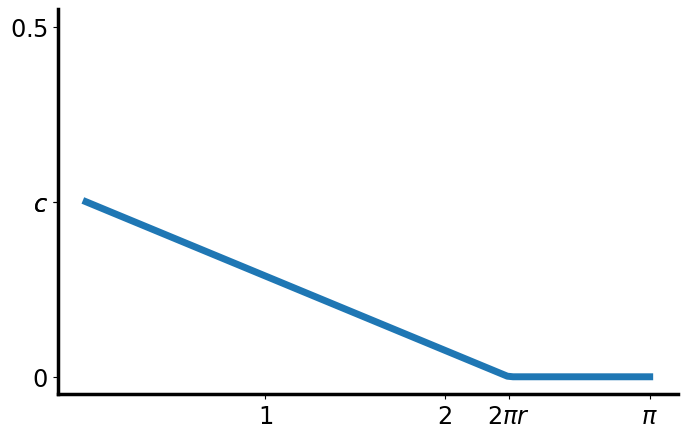

In [15]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

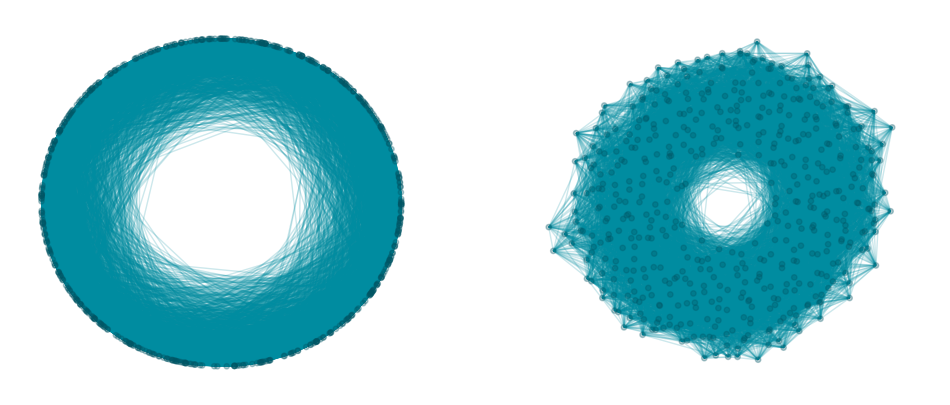

In [18]:
netviz_fig = draw_network_visualiztion(builder, N = 2**9, layout = 'both')

### Clustering coefficient

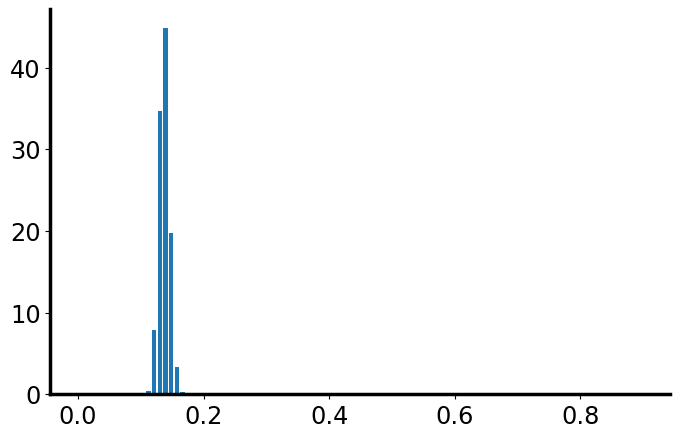

In [19]:
clust = []

for _ in range(N_ENSEMBLE):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.networks.clustering_coefficient(G))

clustdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=100, range=(0, 0.9), 
        rwidth = 0.75, density = True);

# xlabel = ax.set_xlabel('clustering coefficient', fontsize=18)
# ylabel = ax.set_ylabel('frequency', fontsize=18)

In [22]:
c = builder.coupling
r = builder.response
beta = builder.delay

degs_exp = [p for theta in rdist.delaydist.rvs(size=N, beta=beta) for p in np.random.binomial(N-1, rtrafo.local_density(theta=theta, r=r, c=c, beta=beta), size=2**10)]

degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

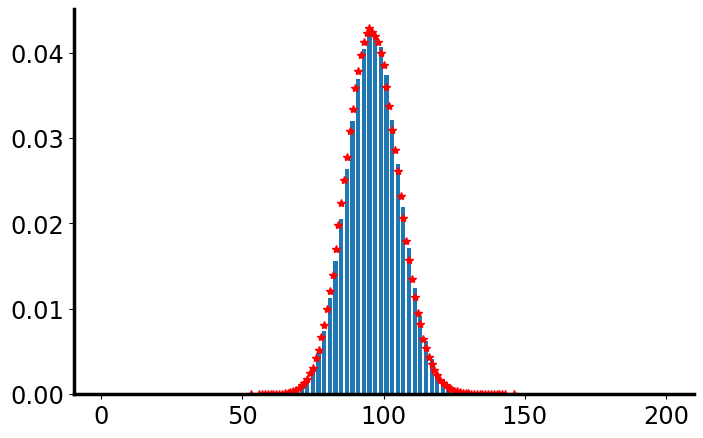

In [23]:
degs = []

for _ in range(2**7):
    G = rng.network_model(N=N, **config_dict[configuration])
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

degdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 100, range = (0, 200),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


#ax.set_xlabel('degree', fontsize=18)
#ax.set_ylabel('frequency', fontsize=18)

### Ring-score distribution

In [24]:
# Get parameter that deviates from default to use ase screening parameter
new_kwargs = {}
for parameter in config_dict[configuration]:
    if config_dict[configuration][parameter] is None:
        continue
    elif config_dict[configuration][parameter] != config_dict['default'][parameter]:
        x_parameter = parameter
    else:
        new_kwargs[parameter] = config_dict[configuration][parameter]

In [25]:
arg_list = np.linspace(0, 1, N_ARG_POINTS+1)[1:]

total = len(arg_list) * N_ENSEMBLE
pbar = tqdm(product(arg_list, range(N_ENSEMBLE)), total = total)

score = defaultdict(list)
for arg, _ in pbar:
    G = rng.network_model(N = N, **new_kwargs, **{x_parameter : arg})
    try:
        score[arg].append(rng.ring_score(G))
    except rexceptions.DisconnectedGraphError:
        continue

100%|█████████████████████████████████████████| 128/128 [14:56<00:00,  7.01s/it]


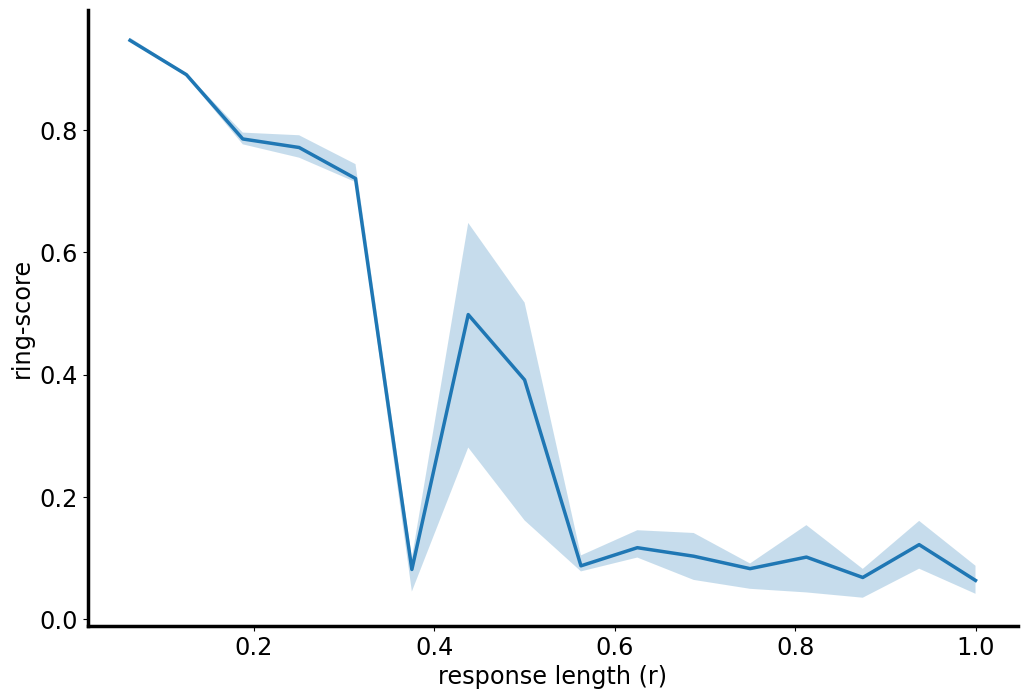

In [26]:
chunks_score_df = [
    pd.DataFrame(scores, columns=['score']).assign(**{x_parameter:arg}) for arg, scores in score.items()
]

score_df = pd.concat(chunks_score_df, ignore_index=True)
plot_df = score_df.groupby(x_parameter).describe()['score']

ringdist_fig, ax = plt.subplots(figsize = (12,8))

ax.plot(plot_df.index, plot_df['mean'], linewidth = 2.5)
ax.fill_between(plot_df.index, plot_df['25%'], plot_df['75%'], alpha = 0.25)

xlabel = ax.set_xlabel('response length (r)')
ylabel = ax.set_ylabel('ring-score')

### Saving plots

In [27]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png")
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf")

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")

# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.png")
# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.pdf")

# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.png")
# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.pdf")

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png")
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf")

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png")
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf")

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png")
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf")

---

## Stronger coupling

In [20]:
configuration = 'stronger_coupling'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **config_dict[configuration])

### Interaction function

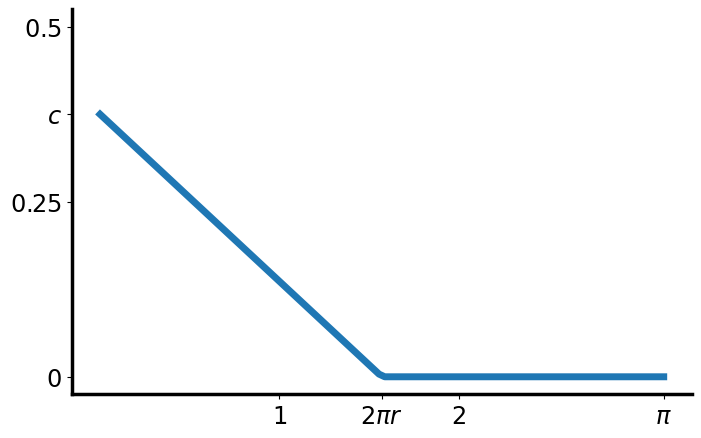

In [29]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

In [30]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

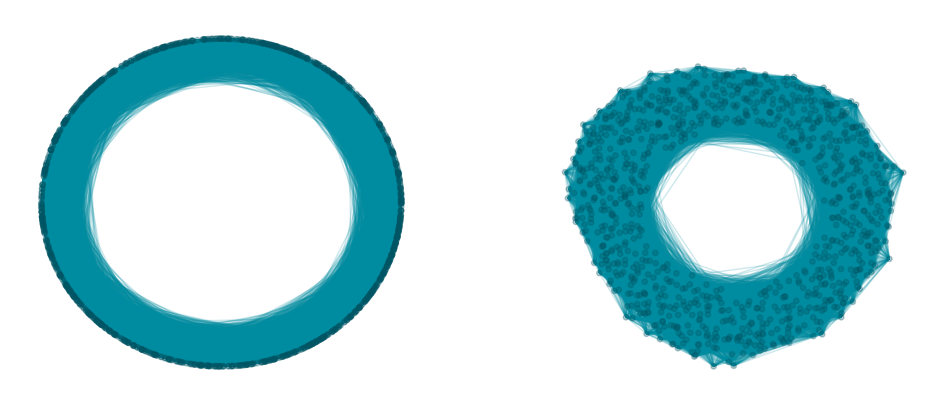

In [31]:
netviz_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.set_xlim(-1.175,1.175)
ax1.set_ylim(-1.175,1.175)

ax2.set_xlim(-1.175,1.175)
ax2.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax1, pos = circ_layout)
rng.plot_nx(G, ax=ax2, pos = spring_layout)

### Clustering coefficient and degree distribution

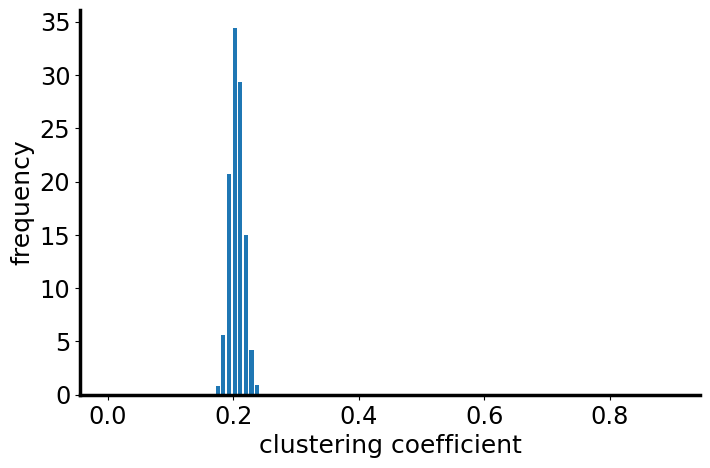

In [32]:
clust = []

for _ in range(N_ENSEMBLE):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.networks.clustering_coefficient(G))

clustdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=100, range=(0, 0.9), 
        rwidth = 0.75, density = True);

xlabel = ax.set_xlabel('clustering coefficient', fontsize=18)
ylabel = ax.set_ylabel('frequency', fontsize=18)

In [33]:
c = builder.coupling
r = builder.response
beta = builder.delay

degs_exp = [p for theta in rdist.delaydist.rvs(size=N, beta=beta) for p in np.random.binomial(N-1, rtrafo.local_density(theta=theta, r=r, c=c, beta=beta), size=2**10)]

degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

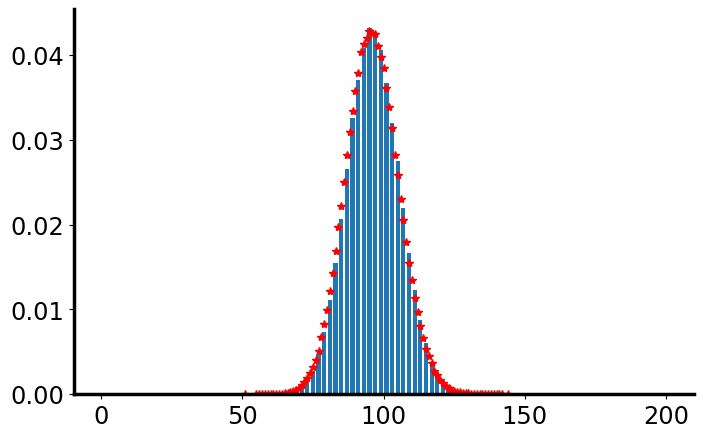

In [34]:
degs = []

for _ in range(2**7):
    G = rng.network_model(N=N, **config_dict[configuration])
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

degdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 100, range = (0, 200),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


#ax.set_xlabel('degree', fontsize=18)
#ax.set_ylabel('frequency', fontsize=18)

### Ring-score distribution

In [35]:
# Get parameter that deviates from default to use ase screening parameter
new_kwargs = {}
for parameter in config_dict[configuration]:
    if config_dict[configuration][parameter] is None:
        continue
    elif config_dict[configuration][parameter] != config_dict['default'][parameter]:
        x_parameter = parameter
    else:
        new_kwargs[parameter] = config_dict[configuration][parameter]

In [36]:
arg_list = np.linspace(0, 1, N_ARG_POINTS+1)[1:]

total = len(arg_list) * N_ENSEMBLE
pbar = tqdm(product(arg_list, range(N_ENSEMBLE)), total = total)

score = defaultdict(list)
for arg, _ in pbar:
    G = rng.network_model(N = N, **new_kwargs, **{x_parameter : arg})
    try:
        score[arg].append(rng.ring_score(G))
    except rexceptions.DisconnectedGraphError:
        continue

100%|█████████████████████████████████████████| 128/128 [25:57<00:00, 12.17s/it]


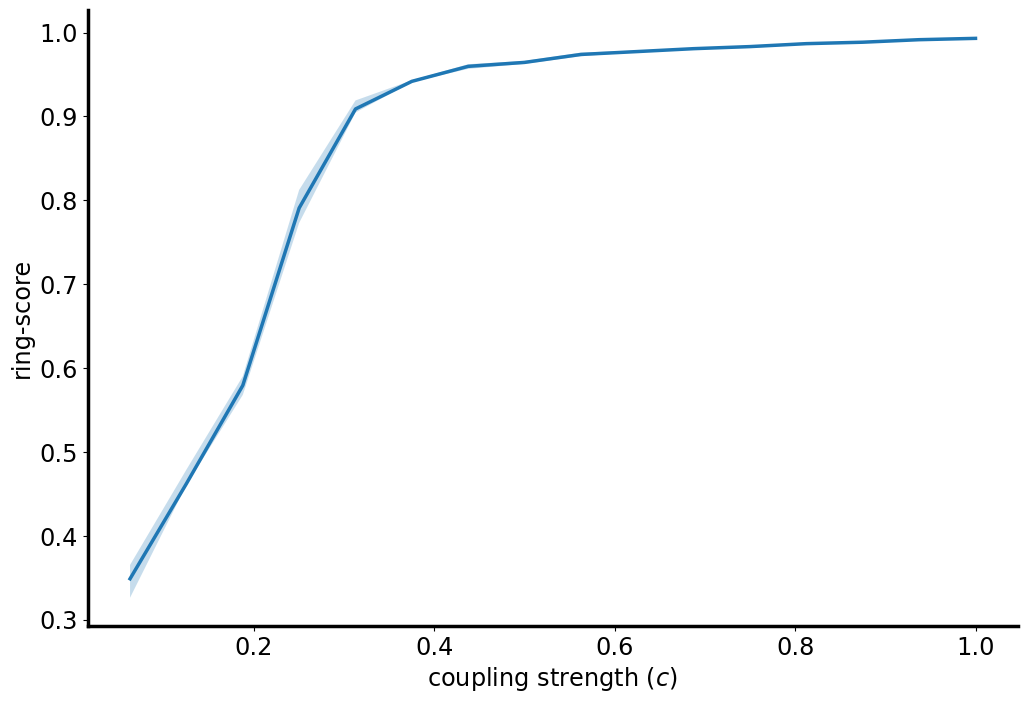

In [37]:
chunks_score_df = [
    pd.DataFrame(scores, columns=['score']).assign(c=arg) for arg, scores in score.items()
]

score_df = pd.concat(chunks_score_df, ignore_index=True)
plot_df = score_df.groupby('c').describe()['score']

ringdist_fig, ax = plt.subplots(figsize = (12,8))

ax.plot(plot_df.index, plot_df['mean'], linewidth = 2.5)
ax.fill_between(plot_df.index, plot_df['25%'], plot_df['75%'], alpha = 0.25)

xlabel = ax.set_xlabel(r'coupling strength ($c$)')
ylabel = ax.set_ylabel('ring-score')

### Saving plots

In [38]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png")
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf")

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")

# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.png")
# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.pdf")

# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.png")
# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.pdf")

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png")
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf")

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png")
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf")

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png")
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf")

## Shorter delay

In [39]:
configuration = 'shorter_delay'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **config_dict[configuration])

### Interaction function

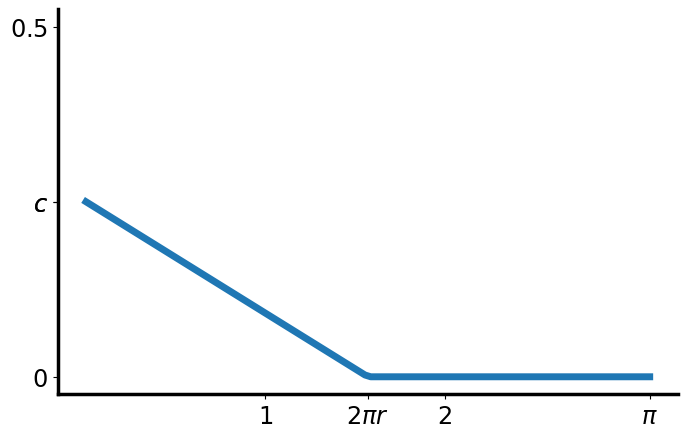

In [40]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

In [41]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

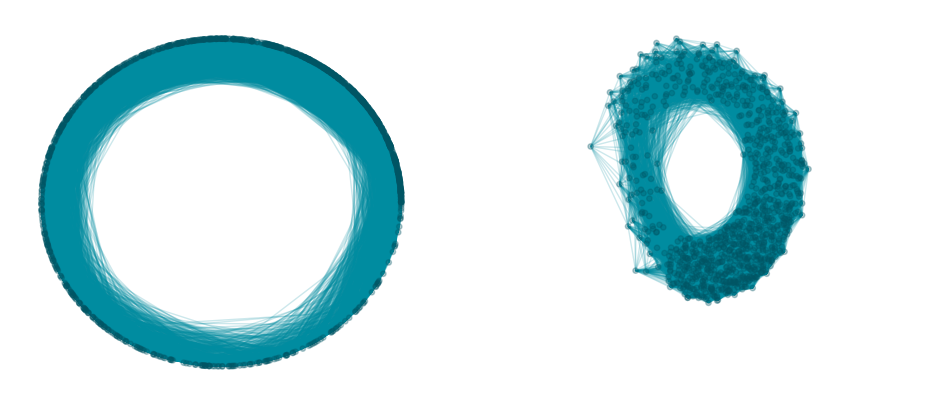

In [42]:
netviz_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.set_xlim(-1.175,1.175)
ax1.set_ylim(-1.175,1.175)

ax2.set_xlim(-1.175,1.175)
ax2.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax1, pos = circ_layout)
rng.plot_nx(G, ax=ax2, pos = spring_layout)

### Clustering coefficient and degree distribution

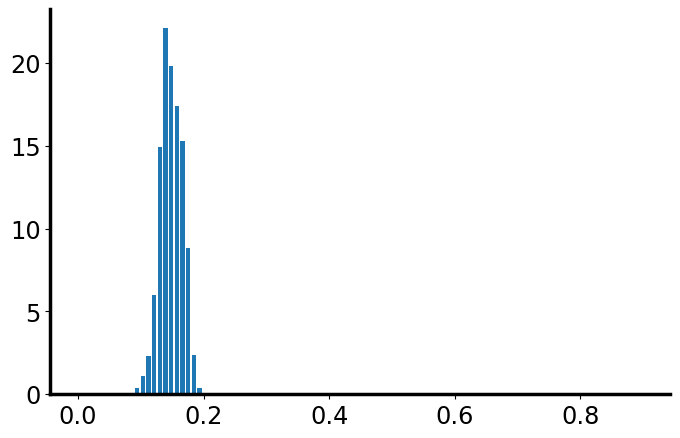

In [43]:
clust = []

for _ in range(N_ENSEMBLE):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.networks.clustering_coefficient(G))

clustdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=100, range=(0, 0.9), 
        rwidth = 0.75, density = True);

# xlabel = ax.set_xlabel('clustering coefficient', fontsize=18)
# ylabel = ax.set_ylabel('frequency', fontsize=18)

In [44]:
c = builder.coupling
r = builder.response
beta = builder.delay

degs_exp = [p for theta in rdist.delaydist.rvs(size=N, beta=beta) for p in np.random.binomial(N-1, rtrafo.local_density(theta=theta, r=r, c=c, beta=beta), size=2**10)]

degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

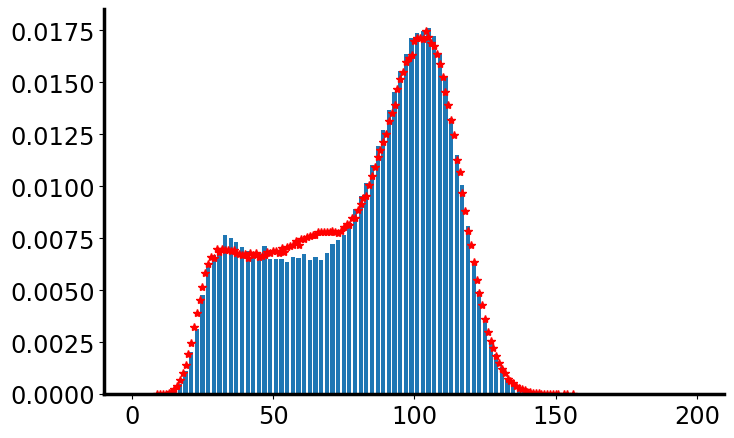

In [45]:
degs = []

for _ in range(2**7):
    G = rng.network_model(N=N, **config_dict[configuration])
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

degdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 100, range = (0, 200),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


#ax.set_xlabel('degree', fontsize=18)
#ax.set_ylabel('frequency', fontsize=18)

### Ring-score distribution

In [46]:
# Get parameter that deviates from default to use ase screening parameter
new_kwargs = {}
for parameter in config_dict[configuration]:
    if config_dict[configuration][parameter] is None:
        continue
    elif config_dict[configuration][parameter] != config_dict['default'][parameter]:
        x_parameter = parameter
    else:
        new_kwargs[parameter] = config_dict[configuration][parameter]

In [47]:
arg_list = np.linspace(0, 1, N_ARG_POINTS+1)[1:]

total = len(arg_list) * N_ENSEMBLE
pbar = tqdm(product(arg_list, range(N_ENSEMBLE)), total = total)

score = defaultdict(list)
for arg, _ in pbar:
    G = rng.network_model(N = N, **new_kwargs, **{x_parameter : arg})
    try:
        score[arg].append(rng.ring_score(G))
    except rexceptions.DisconnectedGraphError:
        continue

100%|█████████████████████████████████████████| 128/128 [10:54<00:00,  5.11s/it]


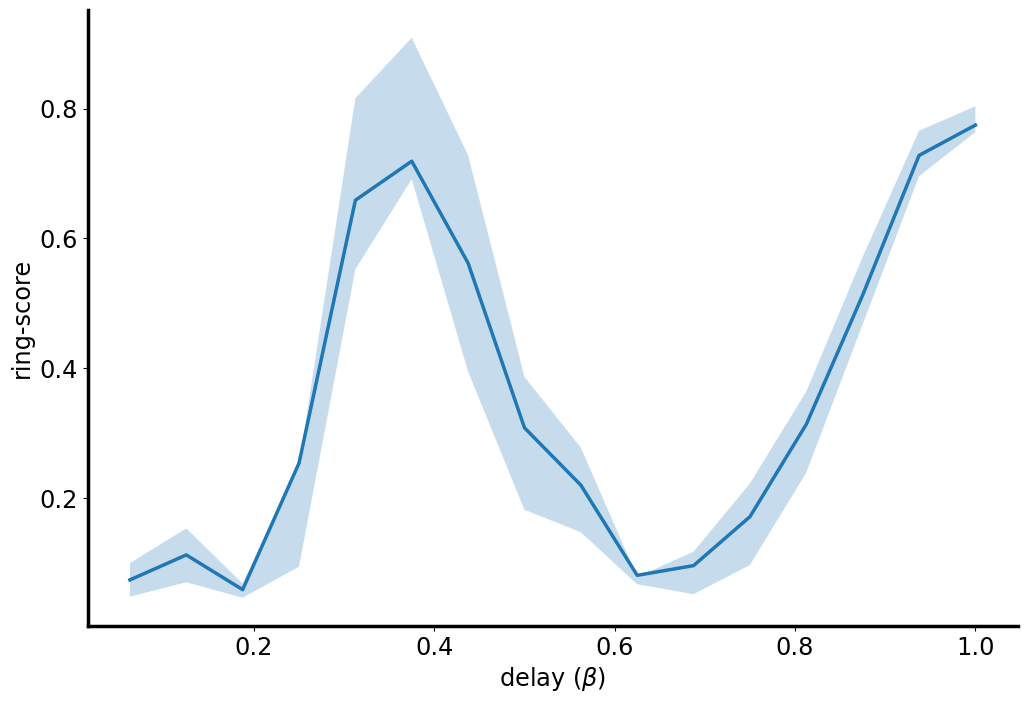

In [48]:
chunks_score_df = [
    pd.DataFrame(scores, columns=['score']).assign(c=arg) for arg, scores in score.items()
]

score_df = pd.concat(chunks_score_df, ignore_index=True)
plot_df = score_df.groupby('c').describe()['score']

ringdist_fig, ax = plt.subplots(figsize = (12,8))

ax.plot(plot_df.index, plot_df['mean'], linewidth = 2.5)
ax.fill_between(plot_df.index, plot_df['25%'], plot_df['75%'], alpha = 0.25)

xlabel = ax.set_xlabel(r'delay ($\beta$)')
ylabel = ax.set_ylabel('ring-score')

### Save plots

In [49]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png")
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf")

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")

# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.png")
# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.pdf")

# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.png")
# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.pdf")

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png")
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf")

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png")
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf")

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png")
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf")

---

## Higher density with fixed response

In [50]:
configuration = 'higher_density_fixed_response'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **config_dict[configuration])

### Interaction function

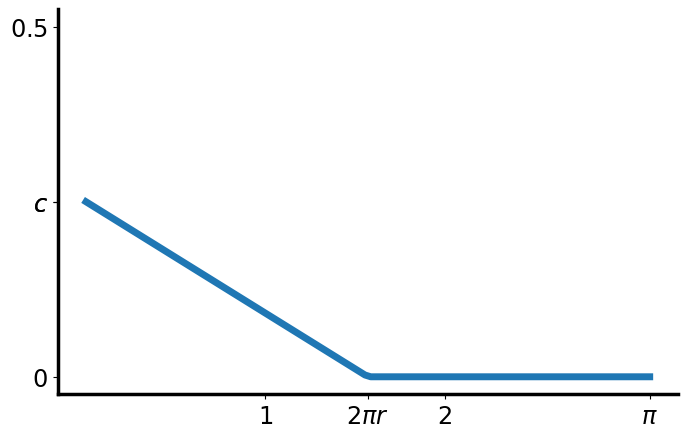

In [51]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

In [52]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

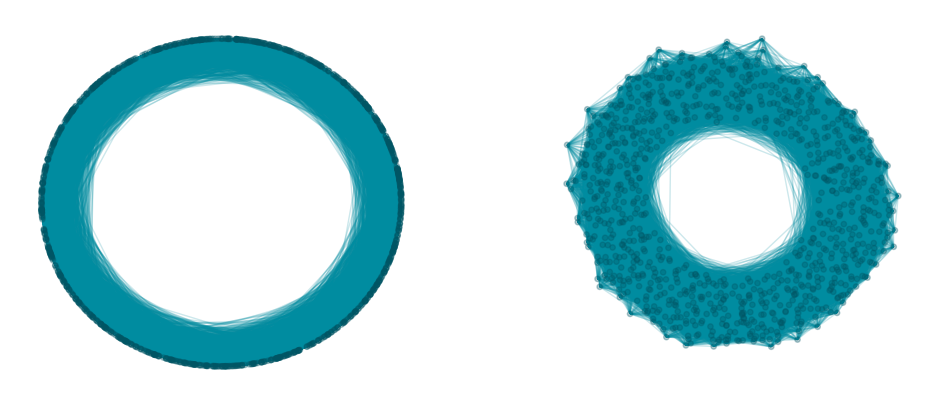

In [53]:
netviz_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.set_xlim(-1.175,1.175)
ax1.set_ylim(-1.175,1.175)

ax2.set_xlim(-1.175,1.175)
ax2.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax1, pos = circ_layout)
rng.plot_nx(G, ax=ax2, pos = spring_layout)

### Clustering coefficient and degree distribution

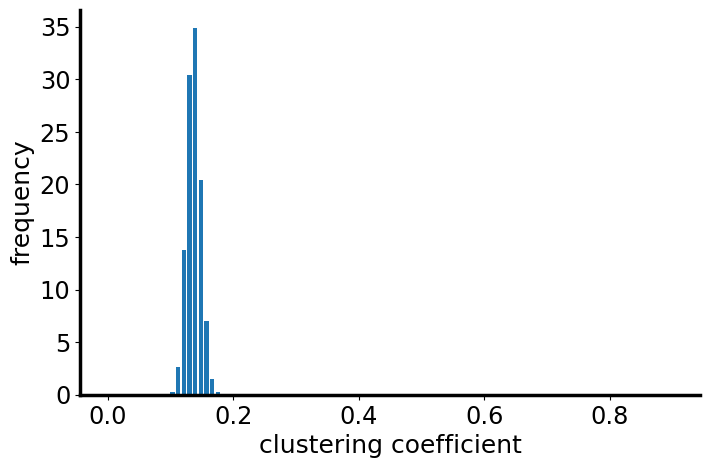

In [54]:
clust = []

for _ in range(N_ENSEMBLE):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.networks.clustering_coefficient(G))

clustdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=100, range=(0, 0.9), 
        rwidth = 0.75, density = True);

xlabel = ax.set_xlabel('clustering coefficient', fontsize=18)
ylabel = ax.set_ylabel('frequency', fontsize=18)

In [55]:
c = builder.coupling
r = builder.response
beta = builder.delay

degs_exp = [p for theta in rdist.delaydist.rvs(size=N, beta=beta) for p in np.random.binomial(N-1, rtrafo.local_density(theta=theta, r=r, c=c, beta=beta), size=2**10)]

degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

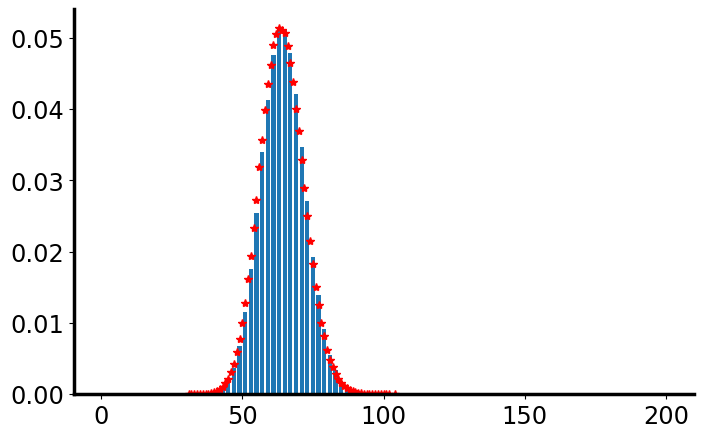

In [56]:
degs = []

for _ in range(2**7):
    G = rng.network_model(N=N, **config_dict[configuration])
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

degdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 100, range = (0, 200),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


#ax.set_xlabel('degree', fontsize=18)
#ax.set_ylabel('frequency', fontsize=18)

### Ring-score distribution

In [57]:
# Get parameter that deviates from default to use ase screening parameter
new_kwargs = {}
for parameter in config_dict[configuration]:
    if config_dict[configuration][parameter] is None:
        continue
    elif config_dict[configuration][parameter] != config_dict['default'][parameter]:
        x_parameter = parameter
    else:
        new_kwargs[parameter] = config_dict[configuration][parameter]

In [58]:
arg_list = np.linspace(0, config_dict[configuration]['r'], N_ARG_POINTS+1)[1:]

total = len(arg_list) * N_ENSEMBLE
pbar = tqdm(product(arg_list, range(N_ENSEMBLE)), total = total)

score = defaultdict(list)
for arg, _ in pbar:
    G = rng.network_model(N = N, **new_kwargs, **{x_parameter : arg})
    try:
        score[arg].append(rng.ring_score(G))
    except rexceptions.DisconnectedGraphError:
        continue

100%|█████████████████████████████████████████| 128/128 [24:57<00:00, 11.70s/it]


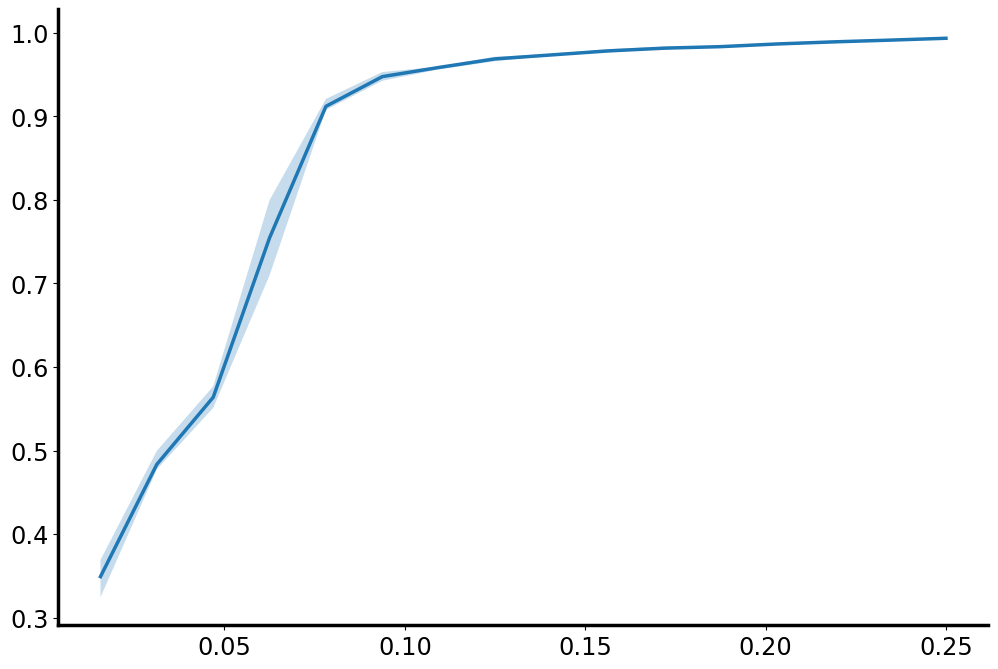

In [59]:
chunks_score_df = [
    pd.DataFrame(scores, columns=['score']).assign(**{x_parameter:arg}) for arg, scores in score.items()
]

score_df = pd.concat(chunks_score_df, ignore_index=True)
plot_df = score_df.groupby(x_parameter).describe()['score']

ringdist_fig, ax = plt.subplots(figsize = (12,8))

ax.plot(plot_df.index, plot_df['mean'], linewidth = 2.5)
ax.fill_between(plot_df.index, plot_df['25%'], plot_df['75%'], alpha = 0.25)

xlabel = ax.set_xlabel(r'density ($\rho$) - fixed response')
ylabel = ax.set_ylabel('ring-score')

### Save plots

In [60]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png")
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf")

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")

# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.png")
# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.pdf")

# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.png")
# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.pdf")

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png")
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf")

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png")
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf")

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png")
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf")

---

## Higher density with fixed coupling

In [61]:
configuration = 'higher_density_fixed_coupling'

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **config_dict[configuration])

### Interaction function

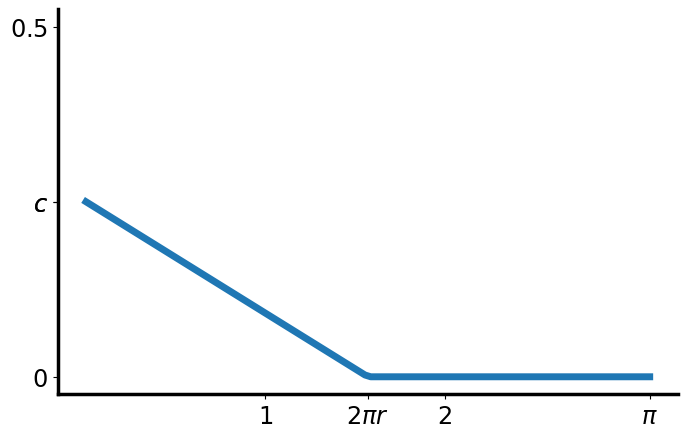

In [62]:
intfunc_fig = draw_interaction_function(builder)

### Network visualization

In [63]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

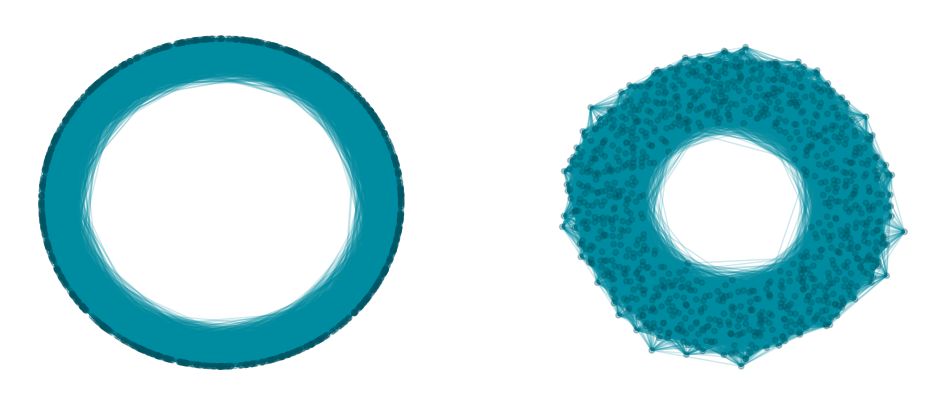

In [64]:
netviz_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.set_xlim(-1.175,1.175)
ax1.set_ylim(-1.175,1.175)

ax2.set_xlim(-1.175,1.175)
ax2.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax1, pos = circ_layout)
rng.plot_nx(G, ax=ax2, pos = spring_layout)

### Clustering coefficient and degree distribution

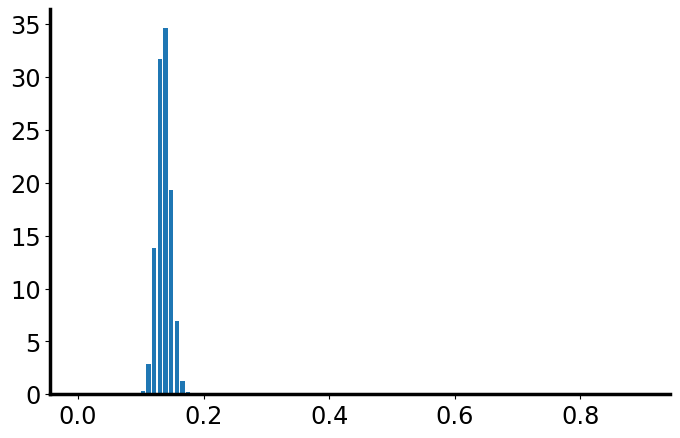

In [65]:
clust = []

for _ in range(N_ENSEMBLE):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.networks.clustering_coefficient(G))

clustdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=100, range=(0, 0.9), 
        rwidth = 0.75, density = True);

# xlabel = ax.set_xlabel('clustering coefficient', fontsize=18)
# ylabel = ax.set_ylabel('frequency', fontsize=18)

In [66]:
c = builder.coupling
r = builder.response
beta = builder.delay

degs_exp = [p for theta in rdist.delaydist.rvs(size=N, beta=beta) for p in np.random.binomial(N-1, rtrafo.local_density(theta=theta, r=r, c=c, beta=beta), size=2**10)]

degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

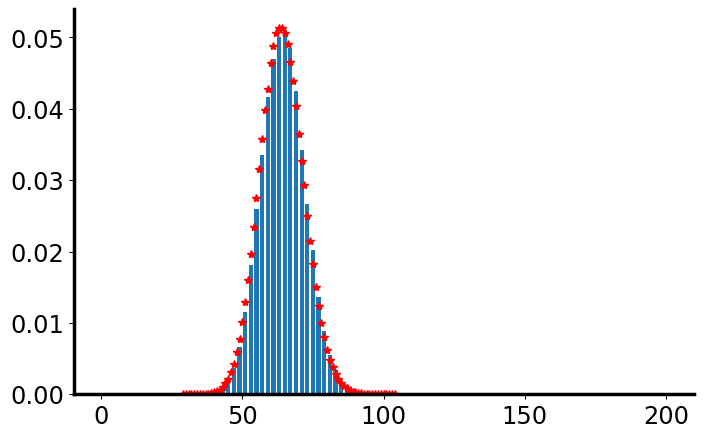

In [67]:
degs = []

for _ in range(2**7):
    G = rng.network_model(N=N, **config_dict[configuration])
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

degdist_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 100, range = (0, 200),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


#ax.set_xlabel('degree', fontsize=18)
#ax.set_ylabel('frequency', fontsize=18)

### Ring-score distribution

In [68]:
# Get parameter that deviates from default to use ase screening parameter
new_kwargs = {}
for parameter in config_dict[configuration]:
    if config_dict[configuration][parameter] is None:
        continue
    elif config_dict[configuration][parameter] != config_dict['default'][parameter]:
        x_parameter = parameter
    else:
        new_kwargs[parameter] = config_dict[configuration][parameter]

In [69]:
arg_list = np.linspace(0, config_dict[configuration]['c'], N_ARG_POINTS+1)[1:]

total = len(arg_list) * N_ENSEMBLE
pbar = tqdm(product(arg_list, range(N_ENSEMBLE)), total = total)

score = defaultdict(list)
for arg, _ in pbar:
    G = rng.network_model(N = N, **new_kwargs, **{x_parameter : arg})
    try:
        score[arg].append(rng.ring_score(G))
    except rexceptions.DisconnectedGraphError:
        continue

100%|█████████████████████████████████████████| 128/128 [14:45<00:00,  6.92s/it]


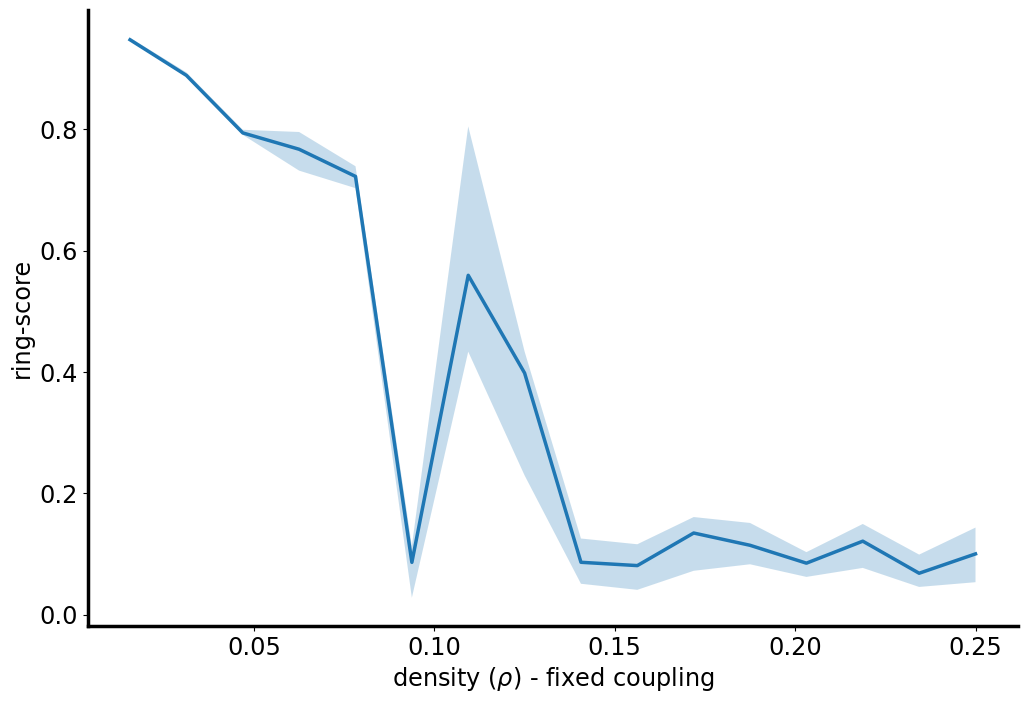

In [70]:
chunks_score_df = [
    pd.DataFrame(scores, columns=['score']).assign(**{x_parameter:arg}) for arg, scores in score.items()
]

score_df = pd.concat(chunks_score_df, ignore_index=True)
plot_df = score_df.groupby(x_parameter).describe()['score']

ringdist_fig, ax = plt.subplots(figsize = (12,8))

ax.plot(plot_df.index, plot_df['mean'], linewidth = 2.5)
ax.fill_between(plot_df.index, plot_df['25%'], plot_df['75%'], alpha = 0.25)

xlabel = ax.set_xlabel(r'density ($\rho$) - fixed coupling')
ylabel = ax.set_ylabel('ring-score')

### Save plots

In [71]:
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.png")
intfunc_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-interactionFunction-{configuration}.pdf")

netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")
netviz_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz-{configuration}.png")

# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.png")
# netviz_circ_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_circular-{configuration}.pdf")

# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.png")
# netviz_spri_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-networkviz_spring-{configuration}.pdf")

clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.png")
clustdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-clusteringdist-{configuration}.pdf")

degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.png")
degdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-degreedist-{configuration}.pdf")

ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.png")
ringdist_fig.savefig(DIRNAME_PLOTS / f"Fig3-modelparameters-scoredist-{configuration}.pdf")

---

## Wrap up

In [72]:
t2 = time.time()

In [73]:
T = round(t2-t1)

print(f"Time to run the notebook: {timedelta(seconds=T)}")

Time to run the notebook: 1:36:24
